In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.7 MB/s eta 0:00:00


In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-10-10 09:44:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-10 09:44:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-10 09:44:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import contractions
import string
import re

In [8]:
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

# Download required resources for tokenize and remove stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

# Download required resources for lemmatization and POS tagging
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [9]:
df = pd.read_csv(path + "/IMDB Dataset.csv")

Data Pre-Processing

In [10]:
def clean_text(text):
   # 1. Lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 3. Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # 4. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 5. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 6. Remove extra whitespaces
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    return text

In [11]:
def expand_contractions(text):
    return contractions.fix(text)

In [12]:
def tokenize_and_remove_stopwords(text):
    # Tokenize
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    return words

In [13]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    pos_tags = pos_tag(tokens)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return lemmatized_words

In [14]:
def handle_negations(tokens):
    negation_words = {"not", "no", "never", "none", "cannot", "n't"}
    new_tokens = []
    negate = False

    for word in tokens:
        if word in negation_words:
            negate = True
            continue
        if negate:
            new_tokens.append("NOT_" + word)
            negate = False
        else:
            new_tokens.append(word)
    return new_tokens


In [15]:
df['cleaned_review'] = df['review'].apply(clean_text)
df['expanded_review'] = df['cleaned_review'].apply(expand_contractions)
df['tokens'] = df['expanded_review'].apply(tokenize_and_remove_stopwords)
df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens)
df['final_tokens'] = df['lemmatized_tokens'].apply(handle_negations)

In [18]:
df.head(5)

,review,sentiment,cleaned_review,expanded_review,tokens,lemmatized_tokens,final_tokens
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, reviewers, mentioned, watching, oz, epis...","[one, reviewer, mention, watch, oz, episode, h...","[one, reviewer, mention, watch, oz, episode, h..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...,a wonderful little production the filming tech...,"[wonderful, little, production, filming, techn...","[wonderful, little, production, film, techniqu...","[wonderful, little, production, film, techniqu..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su...","[think, wonderful, way, spend, time, hot, summ...","[think, wonderful, way, spend, time, hot, summ..."
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,basically there is a family where a little boy...,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ...","[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,petter matteis love in the time of money is a ...,"[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,...","[petter, matteis, love, time, money, visually,..."


In [19]:
max_words = 10000
max_len = 200

# Prepare tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['final_tokens'])

# Convert reviews to sequences
sequences = tokenizer.texts_to_sequences(df['final_tokens'])

# Pad sequences to same length
X = pad_sequences(sequences, maxlen=max_len)

In [20]:
# Encode labels
df['sentiment_label'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
y = df['sentiment_label'].values

In [21]:
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))
model.add(Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    20,613,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,613,500 (78.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,613,500 (78.63 MB)

In [24]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 331s 644ms/step - accuracy: 0.6760 - loss: 0.5815 - val_accuracy: 0.8163 - val_loss: 0.4007
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 319s 638ms/step - accuracy: 0.8220 - loss: 0.3938 - val_accuracy: 0.8536 - val_loss: 0.3410
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 333s 660ms/step - accuracy: 0.8380 - loss: 0.3627 - val_accuracy: 0.8609 - val_loss: 0.3278
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 322s 644ms/step - accuracy: 0.8543 - loss: 0.3350 - val_accuracy: 0.8673 - val_loss: 0.3062
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 331s 662ms/step - accuracy: 0.8641 - loss: 0.3201 - val_accuracy: 0.8702 - val_loss: 0.3036


In [25]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 238ms/step


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4961
           1       0.84      0.91      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



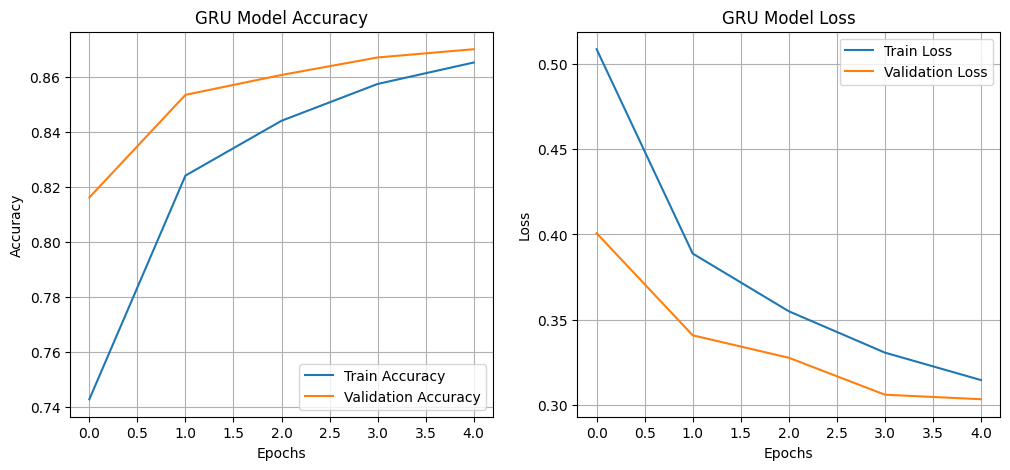

In [27]:
# Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

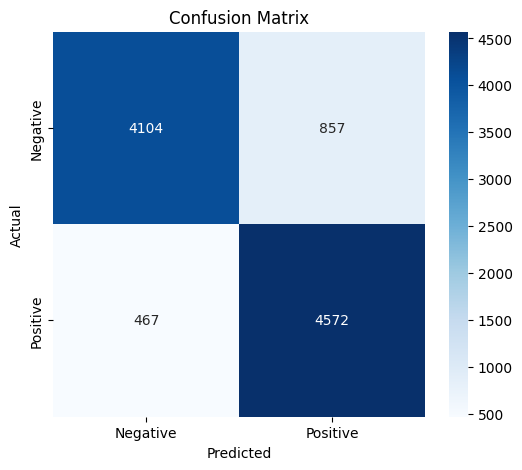

In [29]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()